In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [ ]:
class BasicNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.linear1 = nn.Linear(32*32*3, 1000)
        self.linear2 = nn.Linear(1000, 1000)
        self.linear3 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.softmax(x)

        return x

class BasicDropoutNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.drop1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(32*32*3, 1000)
        self.drop2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(1000, 1000)
        self.drop3 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.drop1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.drop3(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.softmax(x)

        return x

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 2
lr = 0.001

In [ ]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root="CIFAR10", download=True, train=True, transform=transformations)
val_data = datasets.CIFAR10(root="CIFAR10", download=True, train=False, transform=transformations)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train(model, dataloader, optimizer, device="cpu"):
    
    # store loss & accuracy for each epoch
    total_loss = 0.0
    total = 0.0
    correct = 0.0

    model.train()

    for images, labels in dataloader:

        # send stuff to device
        images, labels = images.to(device), labels.to(device)

        # forward pass
        preds = model(images)

        # compute loss with L2-regularization
        loss = loss_fn(preds, labels)

        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        # gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss and accuracy calculations
        total_loss += preds.shape[0] * loss.item()
        _, predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
    train_loss = total_loss / total
    train_accuracy = correct / total

    print(f"[Training] Loss: {train_loss}, Accuracy: {train_accuracy}")
    
    return train_loss, train_accuracy

In [ ]:
def validate(model, dataloader, device="cpu"):
    
    # store loss & accuracy for each epoch
    total_loss = 0.0
    total = 0.0
    correct = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:

            # send stuff to device
            images, labels = images.to(device), labels.to(device)

            # forward pass
            preds = model(images)

            # compute loss
            loss = loss_fn(preds, labels)

            # loss and accuracy calculations
            total_loss += preds.shape[0] * loss.item()
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
    val_loss = total_loss / total
    val_accuracy = correct / total

    print(f"[Validation] Loss: {val_loss}, Accuracy: {val_accuracy}")

    return val_loss, val_accuracy

# AdaGrad

## L2 Only

In [ ]:
adagrad_L2_train_loss = []
adagrad_L2_validation_loss = []
adagrad_L2_train_accuracy = []
adagrad_L2_validation_accuracy = []

In [ ]:
model = BasicNet().to(device)
adagrad_optimizer = optim.Adagrad(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adagrad_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adagrad_L2_train_loss.append(train_loss)
    adagrad_L2_validation_loss.append(val_loss)
    adagrad_L2_train_accuracy.append(train_acc)
    adagrad_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.3102642223358156, Accuracy: 0.34022
[Validation] Epoch: 0
[Validation] Loss: 2.0821542793273924, Accuracy: 0.3841
[Training] Epoch: 1
[Training] Loss: 2.172628790435791, Accuracy: 0.39756
[Validation] Epoch: 1
[Validation] Loss: 2.063885781097412, Accuracy: 0.4041
[Finished Training with AdaGrad]

Total Training Time: 30.609000000054948


## L2 + Dropout

In [ ]:
adagrad_L2D_train_loss = []
adagrad_L2D_validation_loss = []
adagrad_L2D_train_accuracy = []
adagrad_L2D_validation_accuracy = []

In [ ]:
model = BasicDropoutNet().to(device)
adagrad_optimizer = optim.Adagrad(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adagrad_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adagrad_L2D_train_loss.append(train_loss)
    adagrad_L2D_validation_loss.append(val_loss)
    adagrad_L2D_train_accuracy.append(train_acc)
    adagrad_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.4261113577270508, Accuracy: 0.33176
[Validation] Epoch: 0
[Validation] Loss: 2.0893041347503662, Accuracy: 0.3754
[Training] Epoch: 1
[Training] Loss: 2.2800073849487306, Accuracy: 0.37774
[Validation] Epoch: 1
[Validation] Loss: 2.0688642402648925, Accuracy: 0.401
[Finished Training with AdaGrad]

Total Training Time: 28.31200000003446


# RMSProp

In [ ]:
rmsprop_L2_train_loss = []
rmsprop_L2_validation_loss = []
rmsprop_L2_train_accuracy = []
rmsprop_L2_validation_accuracy = []

In [ ]:
model = BasicNet().to(device)
rmsp_optimizer = optim.RMSprop(model.parameters(), lr=lr)

print(f"[Started Training with RMSProp]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, rmsp_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    rmsprop_L2_train_loss.append(train_loss)
    rmsprop_L2_validation_loss.append(val_loss)
    rmsprop_L2_train_accuracy.append(train_acc)
    rmsprop_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with RMSProp]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with RMSProp]
[Training] Epoch: 0
[Training] Loss: 2.243933860321045, Accuracy: 0.27428
[Validation] Epoch: 0
[Validation] Loss: 2.1356786708831788, Accuracy: 0.3134
[Training] Epoch: 1
[Training] Loss: 2.1740883713531494, Accuracy: 0.34922
[Validation] Epoch: 1
[Validation] Loss: 2.0915873737335207, Accuracy: 0.3644
[Finished Training with RMSProp]

Total Training Time: 28.094000000040978


In [ ]:
rmsprop_L2D_train_loss = []
rmsprop_L2D_validation_loss = []
rmsprop_L2D_train_accuracy = []
rmsprop_L2D_validation_accuracy = []

In [ ]:
model = BasicDropoutNet().to(device)
rmsp_optimizer = optim.RMSprop(model.parameters(), lr=lr)

print(f"[Started Training with RMSProp]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, rmsp_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    rmsprop_L2D_train_loss.append(train_loss)
    rmsprop_L2D_validation_loss.append(val_loss)
    rmsprop_L2D_train_accuracy.append(train_acc)
    rmsprop_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with RMSProp]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with RMSProp]
[Training] Epoch: 0
[Training] Loss: 2.341791583328247, Accuracy: 0.20202
[Validation] Epoch: 0
[Validation] Loss: 2.172771076965332, Accuracy: 0.2781
[Training] Epoch: 1
[Training] Loss: 2.3036369523620603, Accuracy: 0.29982
[Validation] Epoch: 1
[Validation] Loss: 2.1390167976379395, Accuracy: 0.3136
[Finished Training with RMSProp]

Total Training Time: 29.20200000004843


# Adam+Nesterov instead of RMSProp+Nesterov

In [ ]:
nadam_L2_train_loss = []
nadam_L2_validation_loss = []
nadam_L2_train_accuracy = []
nadam_L2_validation_accuracy = []

In [ ]:
model = BasicNet().to(device)
nadam_optimizer = optim.NAdam(model.parameters(), lr=lr)

print(f"[Started Training with Adam+Nesterov]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, nadam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    nadam_L2_train_loss.append(train_loss)
    nadam_L2_validation_loss.append(val_loss)
    nadam_L2_train_accuracy.append(train_acc)
    nadam_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with Adam+Nesterov]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with Adam+Nesterov]
[Training] Epoch: 0
[Training] Loss: 2.236728454360962, Accuracy: 0.29398
[Validation] Epoch: 0
[Validation] Loss: 2.10692507019043, Accuracy: 0.3466
[Training] Epoch: 1
[Training] Loss: 2.1723706314849855, Accuracy: 0.35136
[Validation] Epoch: 1
[Validation] Loss: 2.0976485988616944, Accuracy: 0.358
[Finished Training with Adam+Nesterov]

Total Training Time: 28.875000000116415


In [ ]:
nadam_L2D_train_loss = []
nadam_L2D_validation_loss = []
nadam_L2D_train_accuracy = []
nadam_L2D_validation_accuracy = []

In [ ]:
model = BasicDropoutNet().to(device)
nadam_optimizer = optim.NAdam(model.parameters(), lr=lr)

print(f"[Started Training with Adam+Nesterov]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, nadam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    nadam_L2D_train_loss.append(train_loss)
    nadam_L2D_validation_loss.append(val_loss)
    nadam_L2D_train_accuracy.append(train_acc)
    nadam_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with Adam+Nesterov]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with Adam+Nesterov]
[Training] Epoch: 0
[Training] Loss: 2.345062820739746, Accuracy: 0.29746
[Validation] Epoch: 0
[Validation] Loss: 2.1212386558532716, Accuracy: 0.3306
[Training] Epoch: 1
[Training] Loss: 2.3040321712493896, Accuracy: 0.31816
[Validation] Epoch: 1
[Validation] Loss: 2.134014139175415, Accuracy: 0.3197
[Finished Training with Adam+Nesterov]

Total Training Time: 28.391000000061467


# AdaDelta

In [ ]:
adadelta_L2_train_loss = []
adadelta_L2_validation_loss = []
adadelta_L2_train_accuracy = []
adadelta_L2_validation_accuracy = []

In [ ]:
model = BasicNet().to(device)
adadelta_optimizer = optim.Adadelta(model.parameters(), lr=lr)

print(f"[Started Training with AdaDelta]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adadelta_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adadelta_L2_train_loss.append(train_loss)
    adadelta_L2_validation_loss.append(val_loss)
    adadelta_L2_train_accuracy.append(train_acc)
    adadelta_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaDelta]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaDelta]
[Training] Epoch: 0
[Training] Loss: 2.9713887866210937, Accuracy: 0.11606
[Validation] Epoch: 0
[Validation] Loss: 2.3023068241119384, Accuracy: 0.1151
[Training] Epoch: 1
[Training] Loss: 2.9701991413116455, Accuracy: 0.12232
[Validation] Epoch: 1
[Validation] Loss: 2.3021559761047365, Accuracy: 0.1209
[Finished Training with AdaDelta]

Total Training Time: 33.60899999993853


In [ ]:
adadelta_L2D_train_loss = []
adadelta_L2D_validation_loss = []
adadelta_L2D_train_accuracy = []
adadelta_L2D_validation_accuracy = []

In [ ]:
#  L2 + Dropout
model = BasicDropoutNet().to(device)
adadelta_optimizer = optim.Adadelta(model.parameters(), lr=lr)

print(f"[Started Training with AdaDelta]")

tarin_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adadelta_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adadelta_L2D_train_loss.append(train_loss)
    adadelta_L2D_validation_loss.append(val_loss)
    adadelta_L2D_train_accuracy.append(train_acc)
    adadelta_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaDelta]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaDelta]
[Training] Epoch: 0
[Training] Loss: 2.9724113273620607, Accuracy: 0.08796
[Validation] Epoch: 0
[Validation] Loss: 2.302974856185913, Accuracy: 0.0754
[Training] Epoch: 1
[Training] Loss: 2.971285462036133, Accuracy: 0.09236
[Validation] Epoch: 1
[Validation] Loss: 2.3028593906402586, Accuracy: 0.0841
[Finished Training with AdaDelta]

Total Training Time: 62.64100000006147


# Adam

In [ ]:
adam_L2_train_loss = []
adam_L2_validation_loss = []
adam_L2_train_accuracy = []
adam_L2_validation_accuracy = []

In [ ]:
model = BasicNet().to(device)
adam_optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adam_L2_train_loss.append(train_loss)
    adam_L2_validation_loss.append(val_loss)
    adam_L2_train_accuracy.append(train_acc)
    adam_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.2455409614562987, Accuracy: 0.29594
[Validation] Epoch: 0
[Validation] Loss: 2.1167479110717773, Accuracy: 0.3353
[Training] Epoch: 1
[Training] Loss: 2.1906189608001707, Accuracy: 0.34328
[Validation] Epoch: 1
[Validation] Loss: 2.117767768859863, Accuracy: 0.3349
[Finished Training with AdaGrad]

Total Training Time: 27.95299999997951


In [ ]:
adam_L2D_train_loss = []
adam_L2D_validation_loss = []
adam_L2D_train_accuracy = []
adam_L2D_validation_accuracy = []

In [ ]:
model = BasicDropoutNet().to(device)
adam_optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adam_L2D_train_loss.append(train_loss)
    adam_L2D_validation_loss.append(val_loss)
    adam_L2D_train_accuracy.append(train_acc)
    adam_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.3499866526794433, Accuracy: 0.2944
[Validation] Epoch: 0
[Validation] Loss: 2.124327462387085, Accuracy: 0.3253
[Training] Epoch: 1
[Training] Loss: 2.3181008569335937, Accuracy: 0.3135
[Validation] Epoch: 1
[Validation] Loss: 2.123547072601318, Accuracy: 0.3283
[Finished Training with AdaGrad]

Total Training Time: 28.219000000040978


# Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


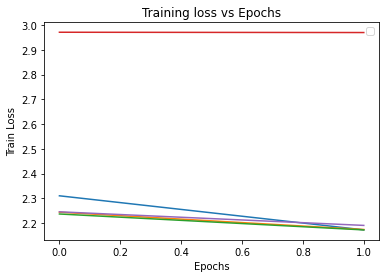

In [ ]:
# Plot L2 train loss vs epochs

plt.legend()
plt.title("Training loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.plot(range(epochs), adagrad_L2_train_loss, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2_train_loss, label="RMSProp")
plt.plot(range(epochs), nadam_L2_train_loss, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2_train_loss, label="AdaDelta")
plt.plot(range(epochs), adam_L2_train_loss, label="Adam")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


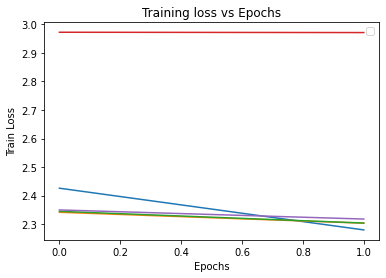

In [ ]:
# Plot L2 + Dropout train loss vs epochs

plt.legend()
plt.title("Training loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.plot(range(epochs), adagrad_L2D_train_loss, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2D_train_loss, label="RMSProp")
plt.plot(range(epochs), nadam_L2D_train_loss, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2D_train_loss, label="AdaDelta")
plt.plot(range(epochs), adam_L2D_train_loss, label="Adam")

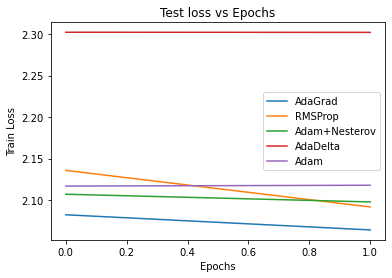

In [ ]:
# Validation - Plot L2 test accuracy vs epochs


plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")

plt.plot(range(epochs), adagrad_L2_validation_accuracy, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2_validation_accuracy, label="RMSProp")
plt.plot(range(epochs), nadam_L2_validation_accuracy, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2_validation_accuracy, label="AdaDelta")
plt.plot(range(epochs), adam_L2_validation_accuracy, label="Adam")
plt.legend()

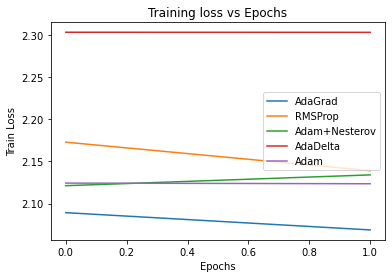

In [ ]:
# Validation - Plot L2 + Dropout test accuracy vs epochs

plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")

plt.plot(range(epochs), adagrad_L2D_validation_accuracy, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2D_validation_accuracy, label="RMSProp")
plt.plot(range(epochs), nadam_L2D_validation_accuracy, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2D_validation_accuracy, label="AdaDelta")
plt.plot(range(epochs), adam_L2D_validation_accuracy, label="Adam")
plt.legend()